In [1]:
import os
import gsw as gsw
import glob
import numpy as np
import netCDF4 as nc
import xarray as xr
import datetime
import time
import numpy.matlib
import matplotlib.ticker as mticker
from pylab import *
from mpl_toolkits.basemap import Basemap
#distance
from pyproj import Geod
geod = Geod(ellps='WGS84')

In [145]:
from tqdm import tqdm_notebook

## First open raw section data files to be interpolated

In [2]:
filedat=glob.glob('./2011*.nc')
print filedat[0]
month =  filedat[0].split('_')[1]
ds=xr.open_dataset(filedat[0])
lat=ds.lat.values
lon=ds.lon.values
stn=ds.station.values
prs=ds.pressure.values
tem=ds.ptemp.values
sal=ds.sal.values

./2011_September_60N_Vavilov_xx_cruise.nc


## Because raw data is not ideal, check whether lat and lon are not mixed up

In [3]:
if lat[1] < 0:
    lon1 = lon
    lon = lat
    lat = lon1

## Now we prepare the data to be stored on the 2d grid

In [4]:
seclen=int(np.amax(stn)-np.amin(stn))+1
# seclen - number of stations according to their numbers in data
print seclen
kk = []
stnvol = np.arange(seclen)
# vol - volume of data at each station, it's got from sorting by station number
#print stnvol
for i in range(seclen):
    k=0
    for j in range(len(lat)):
        if stnvol[i]+1 == int(stn[j])-np.amin(stn):
            k = k+1
    kk.append(k)
print kk
vol = np.amax(kk)
print vol

if kk[-1] == 0:
    seclen=seclen-1

76
[162, 170, 177, 187, 181, 176, 178, 192, 210, 226, 318, 374, 916, 1503, 1589, 1641, 1849, 2019, 2184, 2424, 2612, 2939, 2960, 3037, 3158, 3186, 3136, 3130, 1911, 2824, 2569, 2207, 2084, 1923, 1752, 1521, 1396, 1374, 1703, 1997, 1883, 2266, 2350, 2475, 2548, 2539, 2417, 2471, 2763, 2879, 2855, 2795, 2735, 2761, 2200, 1765, 1080, 1557, 1518, 977, 1003, 1296, 1349, 1488, 1617, 1523, 1022, 1478, 1370, 1124, 1052, 564, 126, 98, 84, 0]
3186


## Now we know the maximum verical volume among all stations, so we can define the "gridded" data:

In [5]:
temp60=np.zeros((seclen,vol))
salt60=np.zeros((seclen,vol))
depth60=np.zeros((seclen,vol))
lat60=np.zeros(seclen)
lon60=np.zeros(seclen)
stn60=np.zeros((seclen,vol))

In [6]:
for i in range(seclen):
    k = 0
    for j in range(len(lat)):
        if stnvol[i]+1 == int(stn[j])-np.amin(stn):
            temp60[i,k] = tem[j]
            salt60[i,k] = sal[j]
            depth60[i,k] = prs[j]
            stn60[i,k] = stn[j]
            lat60[i] = lat[j]
            lon60[i] = lon[j]
            k=k+1

## Now, read the target section grid and any variable, to define where the section exists. 

In [8]:
secfile = './NNATLYS12-V1_m01_60N.nc'
secdat = xr.open_dataset(secfile)
lat=np.squeeze(secdat.nav_lat.values)
lon=np.squeeze(secdat.nav_lon.values)
temp=np.squeeze(secdat.votemper.values)
dep=np.squeeze(secdat.deptht.values)
print temp.shape

(23, 50, 482)


## Define mask - now they all are masked arrays, so we can use it in order to not to compute distances to the masked points

In [9]:
temp60_mask=ma.masked_where(temp60==0.,temp60)
salt60_mask=ma.masked_where(salt60==0.,salt60)

temp_mask=ma.masked_where(temp==0.,temp)

## Compute distances for X1 (raw data) and X2 (gridded data)

In [10]:
dist60=np.zeros(seclen)
# dist60 - distance between stations in meters
dist60[0]=0
for i in np.arange(1,seclen):
    az1,az2,dist=geod.inv(lon60[i-1],lat60[i-1],lon60[i],lat60[i])
    dist60[i]=dist60[i-1]+dist
#print dist60

In [245]:
dist=np.zeros(len(lat))
dist[0]=0
for i in np.arange(1,len(lat)):
    az1,az2,distg=geod.inv(lon[i-1],lat[i-1],lon[i],lat[i])
    dist[i]=dist[i-1]+distg
dist[-1] = dist[-2]+30
#print dist

## Now we have to compute distance between first points of X1 and X2

In [12]:
az1,az2,diff = geod.inv(lon[0], lat[0], lon60[0], lat60[0])
print lon[0], lat[0], lon60[0], lat60[0]
print diff

-43.1277 59.8055 -42.9280014038 59.9410018921
18789.1194867


### Let the model grid to be the reference 0:
If the |lon| > |lon60| then X2dist+diff
Else: X2dist-diff (multiply by -1)

In [14]:
if np.absolute(lon[0]) > np.absolute(lon60[0]):
    dist60new = dist60+diff
else:
    dist60new = dist60-diff
print len(dist60new)

ddist=np.matlib.repmat(dist60new,vol,1)
#print ddist

75


# Lets summarize: 
Target grid starts at 0,0. It has 50 vertical levels and 482 points along the section. Source grid has 1368 or less vertical points and 75 points along the section. 
Except the vertical spacing of the vertical grid, all the distances are spaced evenly. 
So what we do is we flatten all arrays:
- source grid is reduced to the number of points only covered by data and flattened.
- target grid still have nan, which is the key to the back reverting. 

In [227]:
# Make the arrays flatten and equal for sg
dp = depth60.flatten()
ddist = ddist.T
dd = ddist.flatten()
tt = temp60_mask.flatten()
ss = salt60_mask.flatten()
print tt.shape, dd.shape
dist_f = dd[~tt.mask]
dep_f = dp[~tt.mask]
salt_f = ss[~tt.mask]
temp_f = tt[~tt.mask]
print dist_f.shape, dep_f.shape
print dep_f.max()
print ddist.shape, temp60_mask.shape, depth60.shape

(238950,) (238950,)
(124123,) (124123,)
3189.0
(75, 3186) (75, 3186) (75, 3186)


In [228]:
# Make a flatten array for model data
mdep = np.matlib.repmat(dep,len(dist),1).T
mdist=np.matlib.repmat(dist,len(dep),1)
print mdep.shape, mdist.shape
mp = mdep.flatten()
md = mdist.flatten()
mt = temp_mask[0].flatten()
print mp.shape, md.shape, mt.shape
print mp.max()

(50, 482) (50, 482)
(24100,) (24100,) (24100,)
5727.92


## For each dataset we have to correctly define the kx, ky

In [233]:
# X-axis distances
xdiff = []
for i in range(len(lat)):
    #print dist[i]
    xd = dist60 - dist[i]
    xdiff.append(xd)

# Y-axis distances
ydiff = []
for i in range(len(dep)):
    yd = dep_f - dep[i]
    ydiff.append(yd)

kx = 1200/(np.std(xdiff))**2
ky = 15000/(np.std(ydiff))**2

In [217]:
# X-axis distances
xdiff = []
for i in range(len(lat)):
    #print dist[i]
    xd = dist60 - dist[i]
    xdiff.append(xd)

# Y-axis distances
ydiff = []
for i in range(len(dep)):
    yd = dep_f - dep[i]
    ydiff.append(yd)

kx = 120/(np.std(xdiff))**2
ky = 180/(np.std(ydiff))**2

## Here is the start of the main loop

In [239]:
# Start the main loop
t_fin = np.zeros(len(mp))
s_fin = np.zeros(len(mp))
for i in tqdm_notebook(range(len(mp)), total=len(mp)):
    if np.isnan(mt[i])==False:
        xdiff = dist_f - md[i] # md - model dist, dist_f - sg dist
        ydiff = dep_f - mp[i] # mp - model depth, dep_f - sg depth
        wght = np.exp(-kx*(xdiff**2)-ky*(ydiff**2))
#         w_mask = ma.masked_where(wght<=0.1,wght)
#         w_mask = (wght>=0.1)
        w_mask = (wght >= np.sort(wght)[-32])
#         w_filt = wght[~w_mask.mask]
        w_filt = wght[w_mask]
#         x_filt = dist_f[~w_mask.mask]
#         y_filt = dep_f[~w_mask.mask]
#         t_filt = temp_f[~w_mask.mask]
#         s_filt = salt_f[~w_mask.mask]
        t_filt = temp_f[w_mask]
        s_filt = salt_f[w_mask]
        w_norm = w_filt/(w_filt.sum())
        t_fin[i] = (t_filt*w_norm).sum()
        s_fin[i] = (s_filt*w_norm).sum()

In [187]:
i = 78

In [188]:
xdiff = (dist_f - md[i])

In [189]:
xdiff.shape

(124123,)

In [190]:
ydiff = dep_f - mp[i]

In [191]:
ydiff.shape

(124123,)

In [192]:
wght = np.exp(-kx*(xdiff**2)-ky*(ydiff**2))

In [197]:
np.sort(wght)[-8]

0.44592261160916807

In [200]:
w_mask = (wght >= np.sort(wght)[-8])

In [202]:
w_filt = wght[w_mask]

In [203]:
w_filt.shape

(8,)

In [204]:
t_filt = temp_f[w_mask]
s_filt = salt_f[w_mask]

In [205]:
w_norm = w_filt/(w_filt.sum())

In [206]:
w_norm.shape

(8,)

In [207]:
w_norm.sum()

1.0

In [208]:
t_fin[i] = (t_filt*w_norm).sum()
s_fin[i] = (s_filt*w_norm).sum()

In [209]:
t_fin[i]

8.0724256110467252

In [210]:
s_fin[i]

34.574442553090897

In [211]:
t_filt.mean()

8.0639249086380005

In [240]:
tt_fin = np.reshape(t_fin,(50,482))
ss_fin = np.reshape(s_fin,(50,482))
tt_mask=ma.masked_where(tt_fin==0.,tt_fin)
ss_mask=ma.masked_where(ss_fin==0.,ss_fin)

In [243]:
binsf=np.arange(0,12.5,0.1)
binss=np.arange(34.5,36,0.01)
dmax=3500
strlon = [40,5]
strpos = [[150,3400],[2090,3400]]
key = 1

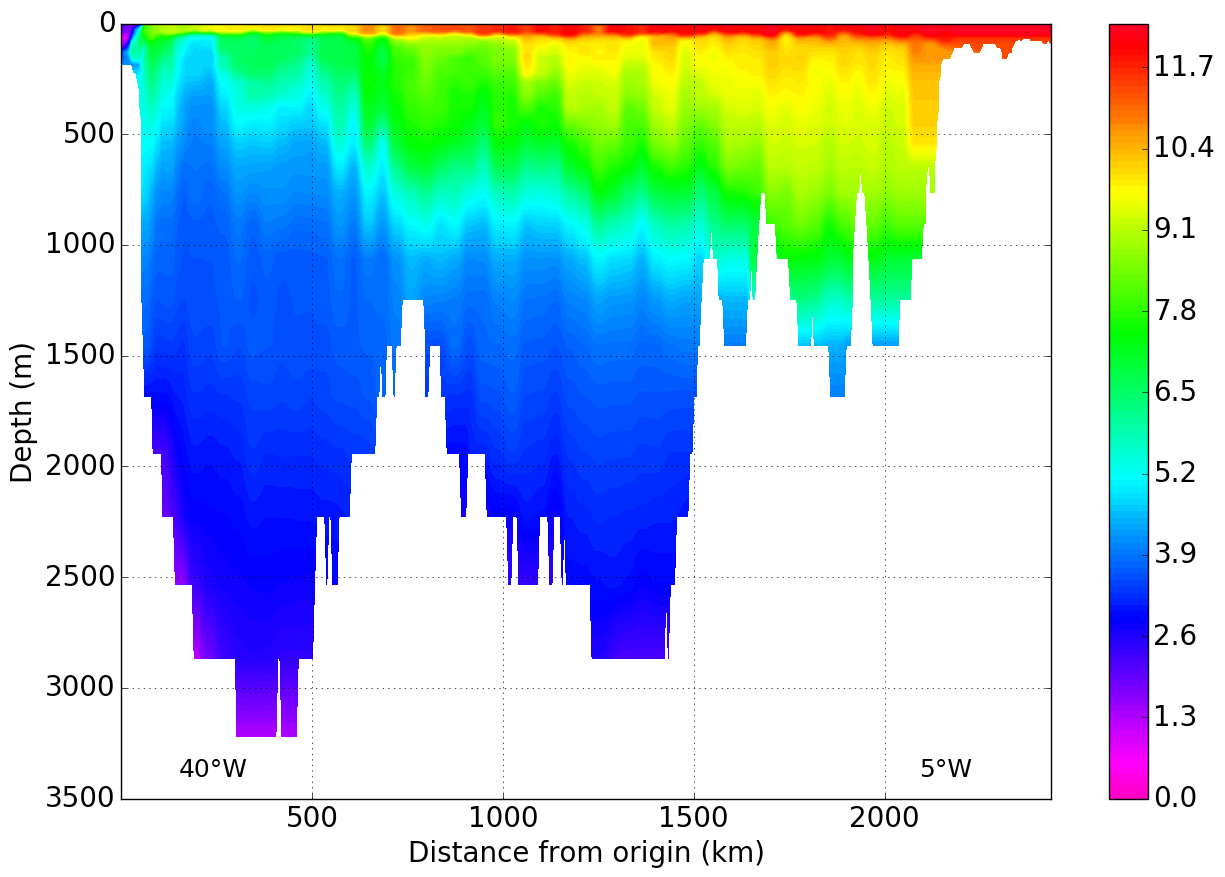

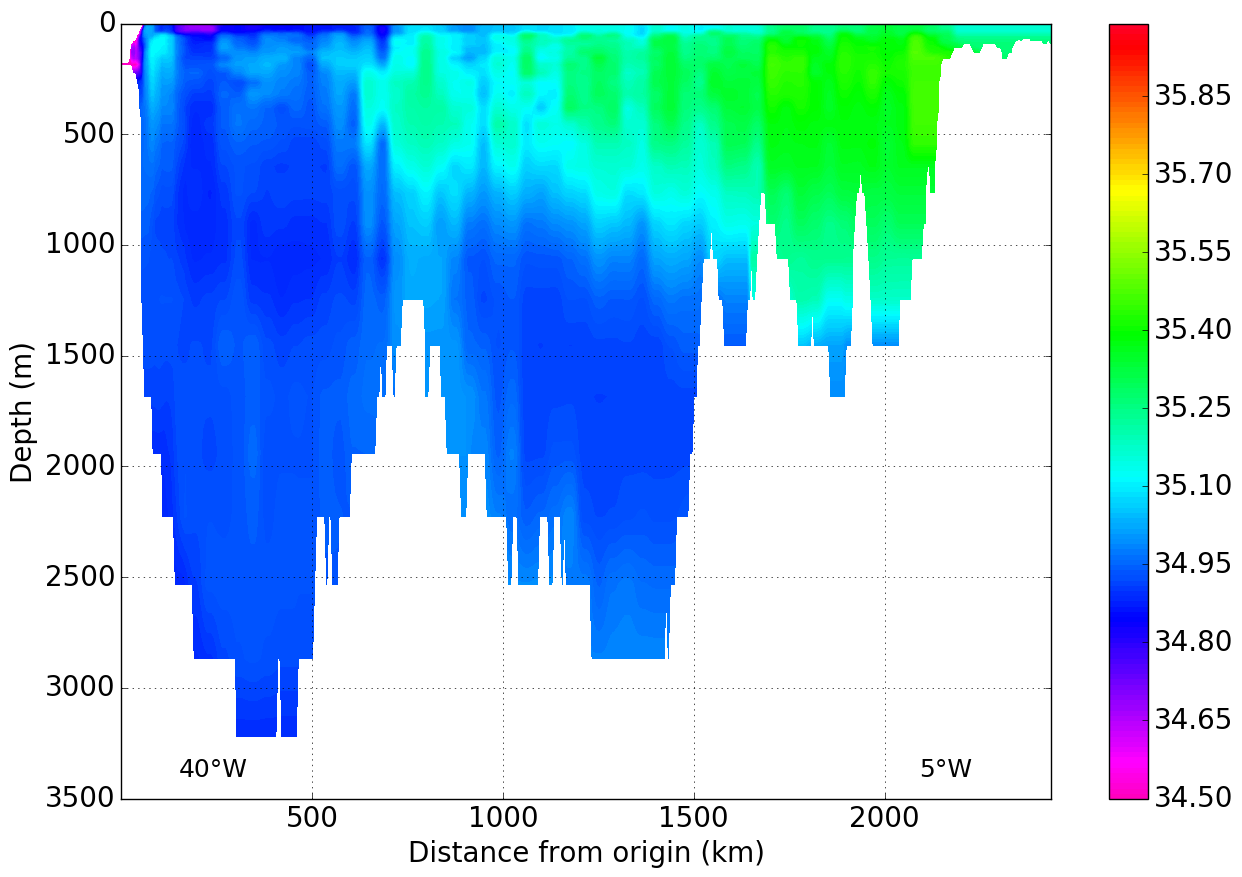

In [244]:
varbs = [tt_mask, ss_mask]
bins = [binsf, binss]
names = ['Temperature','Salinity']
idx = ['temp', 'salt']
for i in range(2):
    fig = plt.figure(figsize=(15,10))
    ax = plt.subplot(111)
    pcolor=plt.contourf(1e-3*dist,dep,varbs[i],bins[i],cmap='gist_rainbow_r')
#     pcolor=plt.contour(1e-3*dist,dep,varbs[i],bins[i],colors='k')
    ax.set_ylabel('Depth (m)',fontsize=20)
    ax.set_xlabel('Distance from origin (km)',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_ylim([dmax,0])
    plt.text(strpos[0][0],strpos[0][1],str(strlon[0])+u'\N{DEGREE SIGN}W',fontsize=18);
    plt.text(strpos[1][0],strpos[1][1],str(strlon[1])+u'\N{DEGREE SIGN}W',fontsize=18);
    tick_locations=np.array([500,1000,1500,2000,2500,3000])
    ax.xaxis.set_major_locator(mticker.FixedLocator(tick_locations))
    ax.grid(True)
    cbar=plt.colorbar(pcolor)
    cbar.ax.tick_params(labelsize=20)
    #plt.title(names[i]+' '+secn+' '+mont,fontsize=20)
    plt.show()

In [258]:
# output netcdf file creation
section = nc.Dataset('./60N_2011.nc', 'w', format='NETCDF4_CLASSIC')
# create dimensions
xax = section.createDimension('xax',482)
yax = section.createDimension('yax',482)
zax = section.createDimension('zax',50)
tax = section.createDimension('time',None)

# create varibles for 3d value
nav_lat = section.createVariable('nav_lat', np.int32,('xax',))
nav_lon = section.createVariable('nav_lon', np.int32,('yax',))
deptht = section.createVariable('deptht', np.int32,('zax',))
votemper = section.createVariable('votemper', np.float32,('zax','xax'))
vosaline = section.createVariable('vosaline', np.float32,('zax','xax'))
# create attributes
section.description = '60N section interpolated on the NNATL12-MPX 60N section subsample'
section.history = 'Created '+time.ctime(time.time())
section.source = '60N section observations from: '+filedat[0]
# create variables attributes
#times.units = 'time in YYYYMMDDHH format'
nav_lat.units = 'latitude'
nav_lon.units = 'longitude'
deptht.units = 'depth in meters'
votemper.units = 'K degrees'
vosaline.units = 'PSU'

print votemper.shape

xax = np.arange(0,482,1)
yax = np.arange(0,482,1)
zax = np.arange(0,50,1)
nav_lat[:] = lat[:]
nav_lon[:] = lon[:]
deptht[:] = dep[:]
votemper[:] = tt_mask[:,:]
vosaline[:] = ss_mask[:,:]
section.close()

(50, 482)


In [236]:
xdiff = np.asarray(xdiff)
ydiff = np.reshape(np.asarray(ydiff), (50,75,3186))
print xdiff.shape, ydiff.shape
print np.std(xdiff), np.std(ydiff)

(482, 75) (50, 75, 3186)
1012717.02908 1749.74459651


## Before we do the essential things, we get kx, ky on the regular grid the grid is done in meters with regular spacing

In [218]:
xx = np.arange(0,2400000,20000)
yy = np.arange(0,6000,50)
xm, ym = np.meshgrid(xx,yy)
print xx.shape, yy.shape

(120,) (120,)


In [219]:
# X-axis distances
#xdiff = np.zeros(len(seclen))
xdiff = []
for i in range(len(lat)):
    #print dist[i]
    xd = xx - dist[i]
    xdiff.append(xd)
#print xdiff[320]

In [220]:
# Y-axis distances
ydiff = []
for i in range(len(dep)):
    yd = yy - dep[i]
    ydiff.append(yd)

In [221]:
xdiff = np.asarray(xdiff)
ydiff = np.asarray(ydiff)
print xdiff.shape, ydiff.shape
print np.std(xdiff), np.std(ydiff)

(482, 120) (50, 120)
998537.552796 2336.27381208


In [222]:
wght = np.zeros((len(xx),len(yy)))
#kx = 120/(np.std(xdiff))**2
#ky = 160/(np.std(ydiff))**2
print kx, ky
for i in range(len(xx)):
    for j in range(len(yy)):
        wght[i,j] = np.exp(-kx*(xdiff[200,j]**2)-ky*(ydiff[34,i]**2))
        #print wght[i,j]

1.17005161512e-10 5.93738453137e-05


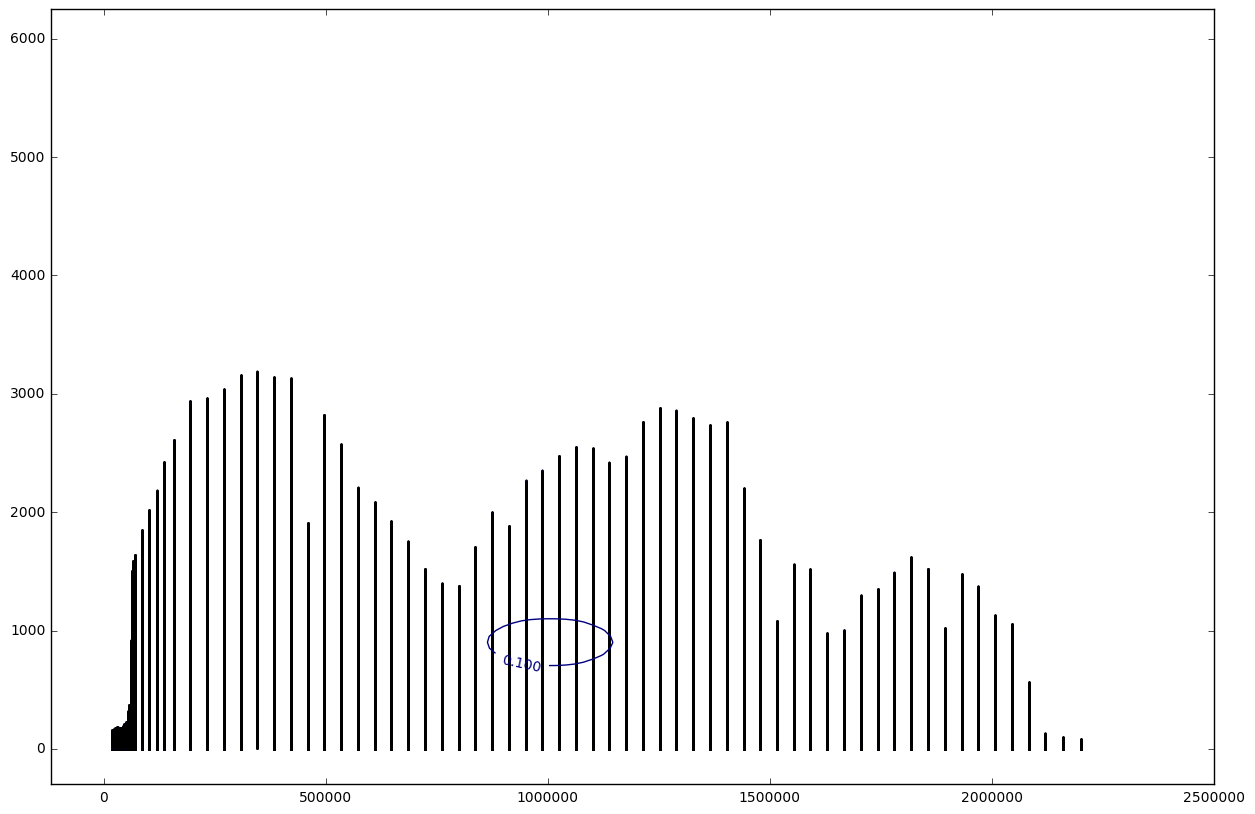

In [223]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
clevs = [0.1]
CS = plt.contour(xx,yy,wght,clevs)
SC = plt.scatter(ddist.T,depth60,s=0.3)
ax.clabel(CS, inline=1, fontsize=10)
plt.show()